In [1]:
%matplotlib inline

In [2]:
from read_sfh import get_scales
small_file_fname = "/Users/aphearin/Dropbox/UniverseMachine/data/histories/small_sfh_catalog_1.002310.txt"
scale_factor_array = get_scales(small_file_fname)
cosmic_age_array = np.load('/Users/aphearin/Dropbox/UniverseMachine/data/histories/prelim_sfh_reduction/times.npy')

In [4]:
from collate_full_catalog import collate_catalog
a_string = 'a_1.002310'
idx_tobs = np.where(scale_factor_array >= float(a_string[2:]))[0][0]
t_today = cosmic_age_array[idx_tobs]

history_colnames = ('halo_id', 'halo_upid', 'halo_mpeak', 'sfr_mp', 'sm_mp', 
                    'stellar_mass', 'sfr', 'a_first_infall', 'halo_mvir', 'halo_vmax')

histories = collate_catalog(a_string, history_colnames=history_colnames)
print("Number of galaxies = {0}".format(len(histories)))

... Assembling history data
Number of galaxies = 676028


In [59]:
from halotools.utils import crossmatch

subhalo_mask = histories['halo_upid'] != -1
subs = histories[subhalo_mask]
idxA, idxB = crossmatch(subs['halo_upid'], histories['halo_id'])

histories['host_mvir'] = histories['halo_mvir']
subs['host_mvir'][idxA] = histories['halo_mvir'][idxB]
histories['host_mvir'][subhalo_mask] = subs['host_mvir']
histories['host_vmax'] = histories['halo_vmax']
subs['host_vmax'][idxA] = histories['halo_vmax'][idxB]
histories['host_vmax'][subhalo_mask] = subs['host_vmax']

In [139]:
from scipy.stats import binned_statistic
cenmask = (histories['gal_type'] == 'central') | (histories['gal_type'] == 'backsplash')

log_mvir_bin_edges = np.linspace(11, 14.5, 65)
median_log_vmax, __, __ = binned_statistic(np.log10(histories['halo_mvir'][cenmask]), 
                 np.log10(histories['halo_vmax'][cenmask]), statistic='median', bins=log_mvir_bin_edges)

log_mvir_bin_mids = 0.5*(log_mvir_bin_edges[1:] + log_mvir_bin_edges[:-1])

interpolated_median_log_vmax = np.interp(np.log10(histories['host_mvir']), 
                                         log_mvir_bin_mids, median_log_vmax)
histories['high_host_vmax'] = True
histories['high_host_vmax'][histories['host_vmax'] < 10**interpolated_median_log_vmax] = False

In [140]:
sm_cut = 10**10.5

satmask = (histories['gal_type'] == 'satellite') & (histories['stellar_mass'] > sm_cut)
all_sats, __ = np.histogram(np.log10(histories['host_mvir'][satmask]), bins=log_mvir_bin_edges)

cenmask = (histories['stellar_mass'] > sm_cut) & ((histories['gal_type'] == 'central') | (histories['gal_type'] == 'backsplash'))
all_cens, __ = np.histogram(np.log10(histories['host_mvir'][cenmask]), bins=log_mvir_bin_edges)

hostmask = histories['halo_upid'] == -1
all_hosts, __ = np.histogram(np.log10(histories['host_mvir'][hostmask]), bins=log_mvir_bin_edges)

mean_nsat_all = all_sats/all_hosts.astype('float')
mean_ncen_all = all_cens/all_hosts.astype('float')

high_host_vmax_satmask = satmask * (histories['high_host_vmax'] == True)
high_host_vmax_sats, __ = np.histogram(np.log10(histories['host_mvir'][high_host_vmax_satmask]), 
                                       bins=log_mvir_bin_edges)

high_host_vmax_cenmask = cenmask * (histories['high_host_vmax'] == True)
high_host_vmax_cens, __ = np.histogram(np.log10(histories['host_mvir'][high_host_vmax_cenmask]), 
                                       bins=log_mvir_bin_edges)

high_host_vmax_hostmask = hostmask * (histories['high_host_vmax'] == True)
high_host_vmax_hosts, __ = np.histogram(np.log10(histories['host_mvir'][high_host_vmax_hostmask]), 
                                       bins=log_mvir_bin_edges)
mean_nsat_high_vmax = high_host_vmax_sats/high_host_vmax_hosts.astype('float')
mean_ncen_high_vmax = high_host_vmax_cens/high_host_vmax_hosts.astype('float')

low_host_vmax_satmask = satmask * (histories['high_host_vmax'] == False)
low_host_vmax_sats, __ = np.histogram(np.log10(histories['host_mvir'][low_host_vmax_satmask]), 
                                       bins=log_mvir_bin_edges)

low_host_vmax_cenmask = cenmask * (histories['high_host_vmax'] == False)
low_host_vmax_cens, __ = np.histogram(np.log10(histories['host_mvir'][low_host_vmax_cenmask]), 
                                       bins=log_mvir_bin_edges)

low_host_vmax_hostmask = hostmask * (histories['high_host_vmax'] == False)
low_host_vmax_hosts, __ = np.histogram(np.log10(histories['host_mvir'][low_host_vmax_hostmask]), 
                                       bins=log_mvir_bin_edges)
mean_nsat_low_vmax = low_host_vmax_sats/low_host_vmax_hosts.astype('float')
mean_ncen_low_vmax = low_host_vmax_cens/low_host_vmax_hosts.astype('float')

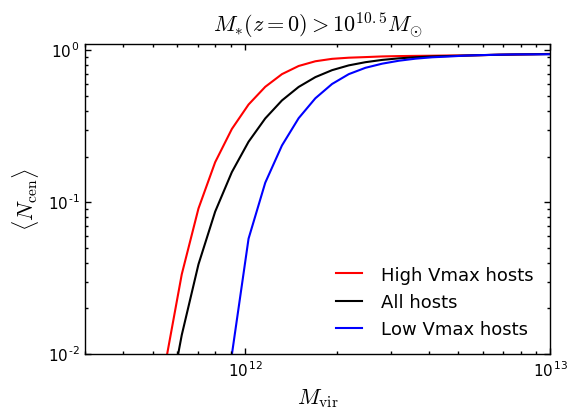

In [141]:
from scipy.signal import savgol_filter, medfilt

fig = plt.figure()
ax = fig.add_subplot(111)

xlabel = ax.set_xlabel(r'$M_{\rm vir}$', fontsize=16)
ylabel = ax.set_ylabel(r'$\langle N_{\rm cen} \rangle$', fontsize=16)
title = ax.set_title(r'$M_{\ast}(z=0) > 10^{10.5}M_{\odot}$', fontsize=16, y=1.02) # y param fixes an overhanging title

ax.plot(10**log_mvir_bin_mids, savgol_filter(mean_ncen_high_vmax, 11, 3), 
        color='red', label=r'High Vmax hosts')
ax.plot(10**log_mvir_bin_mids, savgol_filter(mean_ncen_all, 11, 3), 
        color='k', label=r'All hosts')
ax.plot(10**log_mvir_bin_mids, savgol_filter(mean_ncen_low_vmax, 11, 3), 
        color='blue', label='Low Vmax hosts')
plt.loglog()
plt.xlim(xmin=3e11, xmax=1e13)
plt.ylim(ymin=1e-2, ymax=1.1)

ax.tick_params(axis='x', length=4, width=1, which='major')
ax.tick_params(axis='x', length=2, width=1, which='minor')
ax.tick_params(axis='y', length=4, width=1, which='major')
ax.tick_params(axis='y', length=2, width=1, which='minor')
plt.xticks(fontsize=11); plt.yticks(fontsize=11)

plt.legend(loc='lower right')
fig.savefig('FIGS/universe_machine_decorated_ncen.pdf', 
            bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

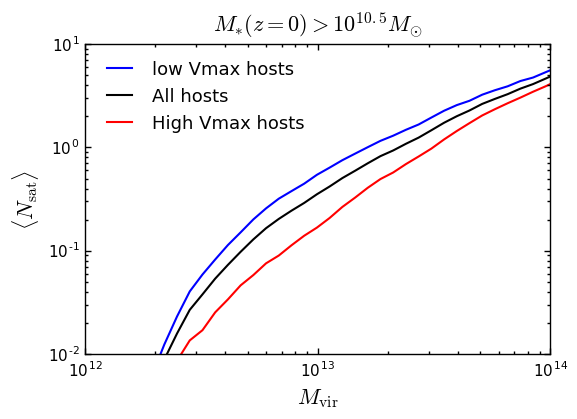

In [147]:
from scipy.signal import savgol_filter, medfilt

fig = plt.figure()
ax = fig.add_subplot(111)

xlabel = ax.set_xlabel(r'$M_{\rm vir}$', fontsize=16)
ylabel = ax.set_ylabel(r'$\langle N_{\rm sat} \rangle$', fontsize=16)
title = ax.set_title(r'$M_{\ast}(z=0) > 10^{10.5}M_{\odot}$', fontsize=16, y=1.02) # y param fixes an overhanging title

ax.plot(10**log_mvir_bin_mids, savgol_filter(mean_nsat_low_vmax, 11, 3), 
        color='blue', label='low Vmax hosts')
ax.plot(10**log_mvir_bin_mids, savgol_filter(mean_nsat_all, 11, 3), 
        color='k', label='All hosts')
ax.plot(10**log_mvir_bin_mids, savgol_filter(mean_nsat_high_vmax, 11, 3), 
        color='red', label='High Vmax hosts')

plt.loglog()
plt.xlim(xmin=1e12, xmax=1e14)
plt.ylim(ymin=1e-2, ymax=10)

ax.tick_params(axis='x', length=4, width=1, which='major')
ax.tick_params(axis='x', length=2, width=1, which='minor')
ax.tick_params(axis='y', length=4, width=1, which='major')
ax.tick_params(axis='y', length=2, width=1, which='minor')
plt.xticks(fontsize=11); plt.yticks(fontsize=11)

plt.legend(loc='upper left')
fig.savefig('FIGS/universe_machine_decorated_nsat.pdf', 
            bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')